<a href="https://colab.research.google.com/github/rohanfaiyazkhan/tabular_classification/blob/main/datamining_a02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Rohan Faiyaz Khan

In [222]:
#! pip install -Uqq numpy pandas scikit-learn

In [223]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

## Trial 0

For this assignment we will create a model that predict product ratings. Let's first run through trial 0 using the same code as provided in the walkthrough.

In [224]:
# Load data
data = pd.read_csv('./drive/MyDrive/Colab Notebooks/train_new.csv').sample(frac=1)
# Ensure rating is one of the 5 levels
data = data.loc[data['rating'].isin([1, 2, 3, 4, 5])]
# Fill null values
data = data.fillna(0)
# Drop columns that we can intuit are not related to the rating. 
# For example id is randomly generated and hence is not relevant to rating
data = data.drop(['merchant_id', 'merchant_profile_picture', 'id', 'tags'], axis=1)


In [225]:
# Split training and validation data with a 70-30 split
msk = np.random.rand(len(data)) < 0.7
tr = data[msk]
val = data[~msk]

In [226]:
dict_cat = {}

cat_cols = tr.columns[tr.dtypes==object].to_list()

# this function will encode columns that are strings as categorical digits
def cat_digit(col):  
    # build the mapping
    encoded = col.astype('category').cat.codes
    # store the mapping
    dict_cat[col.name] = dict(zip(np.asarray(col), np.asarray(encoded)))
    return encoded

# for each categorical feature, apply cat_digit where we build the mapping and transform the data
# this is for the training set (where we build the mapping)
tr[cat_cols] = tr[cat_cols].apply(lambda col: cat_digit(col))




/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


While encoding, we are also saving the encoding-category pairs in the category dictionary `dict_cat`.

In [346]:
print('categorical features')
pprint(list(dict_cat.keys()))

categorical features
['currency_buyer',
 'product_color',
 'product_variation_size_id',
 'shipping_option_name',
 'urgency_text',
 'origin_country',
 'merchant_title',
 'merchant_name',
 'merchant_info_subtitle',
 'theme',
 'crawl_month']


In [228]:
print('Lets see what the mapping for column origin_country :')
pprint(dict_cat['origin_country'])
print('It is a string to integer mapping')

Lets see what the mapping for column origin_country :
{0: 0, 'CN': 1, 'GB': 2, 'US': 3, 'VE': 4}
It is a string to integer mapping


We can see how the mapping inside `dict_cat` looks like for one category.

In [229]:
# then we will use the mappings built from the training set, to transform the validation set
val[cat_cols] = val[cat_cols].apply(lambda col: col.map(dict_cat[col.name]))
# for string values that not seen in training set, we replace it with -1
val = val.fillna(-1)
val

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,product_color,product_variation_size_id,product_variation_inventory,shipping_option_name,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_name,merchant_info_subtitle,merchant_rating_count,merchant_rating,merchant_has_profile_picture,theme,crawl_month
1049,9.0,50,0,5000,0,4.0,985,0,0,0,0,10.0,36.0,50,4.0,3,0,43,50,0.0,0,1.0,-1.0,-1.0,-1.0,7889,3.995056,0,0,0
748,16.0,14,0,100,1,4.0,82,0,0,0,0,63.0,36.0,50,4.0,5,0,36,50,0.0,0,1.0,344.0,183.0,496.0,514,4.217899,0,0,0
197,6.0,6,0,20000,1,4.0,1600,0,0,0,0,29.0,30.0,50,4.0,2,0,33,50,0.0,0,1.0,208.0,458.0,-1.0,16013,4.108849,0,0,0
331,8.0,7,0,10000,1,3.0,1061,0,0,0,0,54.0,31.0,30,4.0,3,0,28,50,0.0,0,1.0,454.0,375.0,419.0,88193,4.080891,1,0,0
655,7.0,6,0,100,1,4.0,14,0,0,0,0,56.0,36.0,50,4.0,2,0,41,50,0.0,0,1.0,-1.0,-1.0,-1.0,7023,4.235939,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,8.0,7,0,100,1,5.0,7,0,0,0,0,13.0,61.0,2,4.0,3,0,37,50,0.0,0,1.0,-1.0,-1.0,-1.0,610,3.814754,0,0,0
865,11.0,10,0,1000,0,4.0,357,0,0,0,0,16.0,36.0,50,4.0,2,0,41,50,0.0,0,1.0,147.0,323.0,366.0,39381,4.066326,0,0,0
846,5.0,5,0,1000,0,4.0,197,0,0,0,0,63.0,31.0,50,4.0,2,0,39,50,0.0,0,1.0,-1.0,-1.0,-1.0,2610,4.158238,0,0,0
395,9.0,8,0,5000,0,4.0,613,0,0,0,0,56.0,61.0,50,4.0,3,0,21,50,0.0,0,1.0,-1.0,-1.0,-1.0,4335,4.057209,0,0,0


In [230]:
# The y or target variable will be the rating column
tr_y = tr['rating']
# The x or features will be every column except rating
tr_x = tr.drop('rating', axis=1)

The model we are using to train is LogisticRegression.

In [231]:
clf = LogisticRegression().fit(tr_x, tr_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [232]:
# Similar to how we extracted x and y from the training data, we will do the same for validation data
val_y = val['rating']
val_x = val.drop('rating', axis=1)
pred_val = clf.predict(val_x)

In [233]:
# F1 score is a weighted measure of accuracy. This can be our metric for evaluation.
val_score = f1_score(val_y, pred_val, average='micro')
# Let's check our baseline
print(val_score)

0.6976047904191617


Going through the entire process, I have a few important observations.
1. The validation data is split from the data through random sampling, and the ratio of training data to validation data is 70-30.
2. Categorical encoding was used to on non-numeric columns
3. Logistic regression was used with no regularization or constraints

Let's think about what we can change for trial 1.

Let's see which features are not particularly related to the rating. We can observe this by looking at the correlation matrix and observing the rating column.

## Trial 1

The first problem is that we have too many features and not all of them are best suited for this classification task. 

I am not sure what the best approach of reducing features is but perhaps we can start with observing correlations.

In [234]:
tr.corr()['rating'].apply(abs).sort_values()

shipping_is_express             0.000902
uses_ad_boosts                  0.001883
badge_local_product             0.002224
merchant_has_profile_picture    0.013531
urgency_text                    0.015481
has_urgency_banner              0.015637
countries_shipped_to            0.018149
badge_fast_shipping             0.019665
merchant_title                  0.021641
units_sold                      0.025774
merchant_name                   0.028643
shipping_option_name            0.031221
rating_count                    0.041481
product_variation_inventory     0.065737
merchant_rating_count           0.070600
inventory_total                 0.082831
product_variation_size_id       0.095825
retail_price                    0.099185
origin_country                  0.106885
product_color                   0.108771
merchant_info_subtitle          0.165314
shipping_option_price           0.192024
price                           0.225098
badges_count                    0.231472
merchant_rating 

We can observe that there is low correlation between rating and some features whereas some others have `NaN`. Training with these features may cause overfitting so let's try dropping the five least correlated features.

In [235]:
sorted_correlations = tr.corr()['rating'].fillna(0).apply(abs).sort_values()
least_correlated = sorted_correlations[:5]
least_correlated

crawl_month            0.000000
currency_buyer         0.000000
theme                  0.000000
shipping_is_express    0.000902
uses_ad_boosts         0.001883
Name: rating, dtype: float64

In [236]:
tr = tr.drop([*(least_correlated.index)], axis=1)


We need to drop the same columns on the validation set.

In [237]:
val = val.drop([*(least_correlated.index)], axis=1)

Just like before let's train the LogisticRegression.

In [238]:
tr_y = tr['rating']
tr_x = tr.drop('rating', axis=1)
clf = LogisticRegression().fit(tr_x, tr_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [239]:
val_y = val['rating']
val_x = val.drop('rating', axis=1)
pred_val = clf.predict(val_x)

In [240]:
val_score = f1_score(val_y, pred_val, average='micro')
print(val_score)

0.7065868263473054


So our accuracy did not particularly change even though we dropped 5 columns. This is a good sign, as we reduced the complexity of our model without loss of accuracy.

## Trial 2

Let's take this one step further and drop all columns below a certain threshold of correlation.

In [302]:
# recreate the data sets
tr = data[msk]
val = data[~msk]
tr[cat_cols] = tr[cat_cols].apply(lambda col: cat_digit(col))
val[cat_cols] = val[cat_cols].apply(lambda col: col.map(dict_cat[col.name]))
val = val.fillna(-1)

feature_correlation_threshold = 0.04 # new hyperparam

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [304]:
tr.corr()['rating'].fillna(0).apply(abs).sort_values()

crawl_month                     0.000000
currency_buyer                  0.000000
theme                           0.000000
shipping_is_express             0.000902
uses_ad_boosts                  0.001883
badge_local_product             0.002224
merchant_has_profile_picture    0.013531
urgency_text                    0.015481
has_urgency_banner              0.015637
countries_shipped_to            0.018149
badge_fast_shipping             0.019665
merchant_title                  0.021641
units_sold                      0.025774
merchant_name                   0.028643
shipping_option_name            0.031221
rating_count                    0.041481
product_variation_inventory     0.065737
merchant_rating_count           0.070600
inventory_total                 0.082831
product_variation_size_id       0.095825
retail_price                    0.099185
origin_country                  0.106885
product_color                   0.108771
merchant_info_subtitle          0.165314
shipping_option_

In [308]:
# this time we use a condition to determine which columns are unrelated
above_correlation_thresh = tr.corr()['rating'].fillna(0).apply(abs) >= feature_correlation_threshold
least_correlated = above_correlation_thresh[above_correlation_thresh == False].index
least_correlated

Index(['currency_buyer', 'units_sold', 'uses_ad_boosts', 'badge_local_product',
       'badge_fast_shipping', 'shipping_option_name', 'shipping_is_express',
       'countries_shipped_to', 'has_urgency_banner', 'urgency_text',
       'merchant_title', 'merchant_name', 'merchant_has_profile_picture',
       'theme', 'crawl_month'],
      dtype='object')

In [309]:
tr = tr.drop([*least_correlated], axis=1)
val = val.drop([*least_correlated], axis=1)

In [310]:
tr

,price,retail_price,rating,rating_count,badges_count,badge_product_quality,product_color,product_variation_size_id,product_variation_inventory,shipping_option_price,inventory_total,origin_country,merchant_info_subtitle,merchant_rating_count,merchant_rating
803,8.00,59,4.0,45,0,0,29,61,5,3,50,1,223,58154,3.871359
641,12.00,17,4.0,103,0,0,63,31,50,3,50,1,212,20478,3.910343
473,14.00,12,4.0,186,0,0,22,56,10,4,50,1,154,288,3.729167
993,5.92,9,4.0,17,0,0,16,61,18,1,50,1,495,5106,4.212887
1091,9.00,48,4.0,135,0,0,54,31,50,3,50,1,155,6632,3.748794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,8.00,7,4.0,5641,0,0,44,64,50,2,50,1,113,70773,4.038320
594,12.00,11,4.0,171,0,0,63,36,7,3,50,1,456,4811,4.194554
449,5.85,13,3.0,602,0,0,16,61,9,2,50,1,215,25631,3.894737
576,14.00,76,4.0,31,0,0,0,36,50,4,50,1,288,51369,3.968269


In [311]:
tr_y = tr['rating']
tr_x = tr.drop('rating', axis=1)
clf = LogisticRegression().fit(tr_x, tr_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [312]:
val_y = val['rating']
val_x = val.drop('rating', axis=1)
pred_val = clf.predict(val_x)

In [313]:
val_score = f1_score(val_y, pred_val, average='micro')
print(val_score)

0.7275449101796408


Some improvement 🤷‍♀️. This shows a lot of the features were simply adding noise to the model. Now we are still facing some issues with Logistic Regression so let's see if we can improve on that.

# Trial 3

One observation throughout the process is that the everytime we run `fit`, we get a warning that says `ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.` The warning also suggests that we do some preprocessing.

So let's do some scaling before we train with our data. ⚖️

In [248]:
def scale_x(tr_x, val_x):
  sc = StandardScaler()
  tr_x_scaled = sc.fit_transform(tr_x)
  val_x_scaled = sc.transform(val_x)
  return tr_x_scaled, val_x_scaled, sc

Let's check how our scaled data looks like.

In [249]:
tr_x_scaled, val_x_scaled,sc = scale_x(tr_x, val_x)

The scaled data is an array, not a dataframe. Hence we can preview what it looks like through indexing.

In [250]:
tr_x_scaled[:3]

array([[-0.05234539,  1.12871388, -0.4203344 , -0.31667239, -0.3034573 ,
        -0.34640061,  1.18170743, -1.28111699,  0.69521194,  0.06381369,
        -0.09786223, -0.48583484,  0.29495485, -0.79415813],
       [ 1.00073663, -0.20229419, -0.39313653, -0.31667239, -0.3034573 ,
         1.12871724, -0.82841346,  0.81229756,  0.69521194,  0.06381369,
        -0.09786223, -0.55069206, -0.08247402, -0.60536346],
       [ 1.52727764, -0.36074753, -0.35421545, -0.31667239, -0.3034573 ,
        -0.65010135,  0.84668728, -1.04851538,  1.69647544,  0.06381369,
        -0.09786223, -0.89266647, -0.28473246, -1.48277699]])

Let's train with this now

In [252]:
clf = LogisticRegression().fit(tr_x_scaled, tr_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


We are still getting this warning. Perhaps there is more we need to change.

In [253]:
pred_val = clf.predict(val_x_scaled)
val_score = f1_score(val_y, pred_val, average='micro')
print(val_score)

0.7455089820359282


That was barely any change at all 🤦‍♂️

Let's peak at the confusion matrix and classification report to see what is going on.

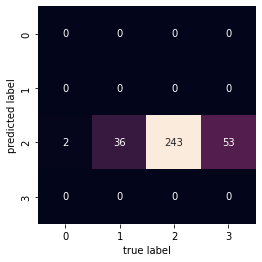

In [347]:
mat = confusion_matrix(val_y, pred_val)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [349]:
print(classification_report(val_y, pred_val))

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00        36
         4.0       0.73      1.00      0.84       243
         5.0       0.00      0.00      0.00        53

    accuracy                           0.73       334
   macro avg       0.18      0.25      0.21       334
weighted avg       0.53      0.73      0.61       334



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It appears our model is predicting everything as the mean value of 4. This is not ideal 📉

# Trial 4

So maybe we are approaching this all wrong. Perhaps the data is not suited to Logistic Regression? Let's try a different model. This is a classification problem and hence we have decision trees and support vector machines at our disposal. Let's try a decision tree based model, RandomForest. For the initial test we will use unscaled data (minus the redundant columns)  

In [255]:
rfc = RandomForestClassifier()

In [256]:
rfc.fit(tr_x, tr_y)
pred_val = rfc.predict(val_x)

In [257]:
val_score = f1_score(val_y, pred_val, average='micro')
print(val_score)

0.811377245508982


In [258]:
print(classification_report(val_y, pred_val))

              precision    recall  f1-score   support

         2.0       1.00      0.50      0.67         2
         3.0       0.53      0.25      0.34        36
         4.0       0.83      0.95      0.89       243
         5.0       0.76      0.55      0.64        53

    accuracy                           0.81       334
   macro avg       0.78      0.56      0.63       334
weighted avg       0.79      0.81      0.79       334



Okay, so without any hyperparameter tweaking we already have a good accuracy. However this model is likely to overfitted to the training data. Let's improve our model a bit by making it more robust and maintainable.

## Trial 5

One thing we can do is tweak the hyperparameters of a RandomForest 👾👾👾

Let's write a function that initializes a random forest with some sensible hyperparams. 

In [259]:
def rf(xs, y, n_estimators=50, max_samples=600,
       max_features=0.5, min_samples_leaf=5, max_leaf_nodes=400, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, max_leaf_nodes=max_leaf_nodes, oob_score=True).fit(xs, y)

In [260]:
rfc = rf(tr_x, tr_y, )

In [261]:
def get_f1_accuracy(m, val_x, val_y):
  pred_val = m.predict(val_x)
  return f1_score(val_y, pred_val, average='micro')

In [262]:
get_f1_accuracy(rfc, val_x, val_y)

0.7784431137724551

So this is a bit finicky because I ran this step lots of times and sometimes I got improvements in performance and sometimes I did not. This indicates I will need to experiment a bit more with the hyperparameters.

In [263]:
print(classification_report(val_y, pred_val))

              precision    recall  f1-score   support

         2.0       1.00      0.50      0.67         2
         3.0       0.53      0.25      0.34        36
         4.0       0.83      0.95      0.89       243
         5.0       0.76      0.55      0.64        53

    accuracy                           0.81       334
   macro avg       0.78      0.56      0.63       334
weighted avg       0.79      0.81      0.79       334



## Trial 6

So now we know that tuning hyperparameters can help improve performance. However, a bottleneck in the performance is still the data which has too many features. Now that we have a simple RandomForest, we can analyze feature importance. 🔍

In [264]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [265]:
feat_importance = rf_feat_importance(rfc, tr_x)
feat_importance

,cols,imp
2,rating_count,0.315273
12,merchant_rating_count,0.124546
13,merchant_rating,0.107922
0,price,0.088318
11,merchant_info_subtitle,0.074057
4,badge_product_quality,0.060663
1,retail_price,0.057086
5,product_color,0.049855
3,badges_count,0.047792
7,product_variation_inventory,0.033065


It's easier to see the relative impact by plotting the feature importances.

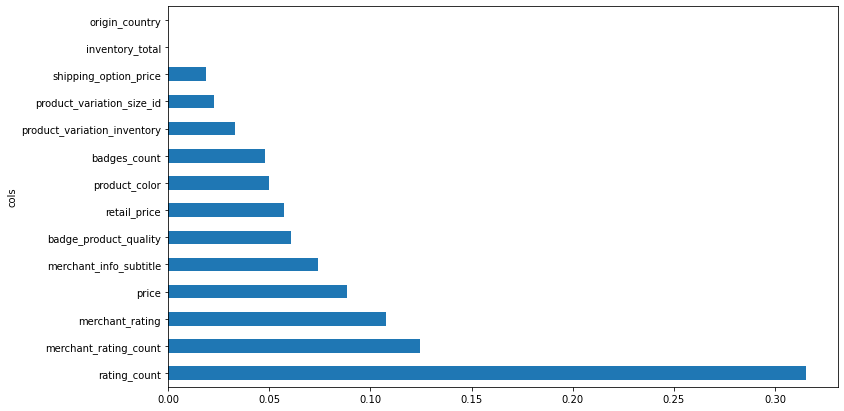

In [266]:
feat_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

Let's consider a threshold of minimum feature importance of 0.02 and drop all columns below this threshold.

In [267]:
feature_importance_threshold = 0.02
cols_to_keep = feat_importance[feat_importance.imp > feature_importance_threshold].cols

In [268]:
tr_x_imp = tr_x[cols_to_keep]
val_x_imp = val_x[cols_to_keep]
len(tr_x.columns), len(tr_x_imp.columns)

(14, 11)

In [269]:
rfc = rf(tr_x_imp, tr_y)
get_f1_accuracy(rfc, val_x_imp, val_y)

0.7874251497005988

Our accuracy from using this model is about the same even though we cut the columns by half. This is really good as we have less data to overfit to. In addition the model is simpler and easier to understand.

## Trial 7

Okay, let's do another round of cleaning data. Random forests provide a built-in validation or test set, called out-of-bag data. This is the data that was skipped in the "bagging" process RandomForests use to sample data. We can check the error against the out-of-bag data, which is called OOB error.

In [270]:
tr_x_imp.columns

Index(['rating_count', 'merchant_rating_count', 'merchant_rating', 'price',
       'merchant_info_subtitle', 'badge_product_quality', 'retail_price',
       'product_color', 'badges_count', 'product_variation_inventory',
       'product_variation_size_id'],
      dtype='object')

In [271]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=15,
        max_samples=500, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, tr_y)
    return m.oob_score_

This will be our baseline OOB. If we can improve on this we may consider dropping another feature.

In [272]:
get_oob(tr_x_imp)

0.7457180500658761

In [273]:
{c:get_oob(tr_x_imp.drop(c, axis=1)) for c in tr_x_imp.columns}

{'badge_product_quality': 0.7417654808959157,
 'badges_count': 0.7457180500658761,
 'merchant_info_subtitle': 0.7483530961791831,
 'merchant_rating': 0.7496706192358367,
 'merchant_rating_count': 0.7496706192358367,
 'price': 0.7430830039525692,
 'product_color': 0.7523056653491436,
 'product_variation_inventory': 0.7470355731225297,
 'product_variation_size_id': 0.7523056653491436,
 'rating_count': 0.7140974967061924,
 'retail_price': 0.7457180500658761}

So we can see that if we remove either `product_variation_size_id` or `product_color`, our OOB score goes up. Let's try removing both of them and calculation F1 Loss. 

In [315]:
tr_even_fewer_cols = tr_x_imp.drop(['product_variation_size_id', 'product_color'], axis=1)
val_even_fewer_cols = val_x_imp.drop(['product_variation_size_id', 'product_color'], axis=1)
get_f1_accuracy(rf(tr_even_fewer_cols, tr_y), val_even_fewer_cols, val_y)

0.7904191616766467

So turns out dropping `product_color` and `product_variation_size_id` offers a slightly improved performance. Let's drop them from the training data.

In [321]:
tr_x_imp = tr_even_fewer_cols
val_x_imp = val_even_fewer_cols

Let's however try scaling one more time. 

In [322]:
tr_x_scaled, val_x_scaled, sc = scale_x(tr_x_imp, val_x_imp)

In [323]:
sc.mean_, sc.var_

(array([9.41371542e+02, 2.87107866e+04, 4.03534363e+00, 8.19882740e+00,
        3.05399209e+02, 8.43214756e-02, 2.33833992e+01, 1.10671937e-01,
        3.25388669e+01]),
 array([4.54764177e+06, 9.96458782e+09, 4.26376589e-02, 1.44276496e+01,
        2.87652912e+04, 7.72113644e-02, 9.95719935e+02, 1.22139074e-01,
        4.62077211e+02]))

In [324]:
tr_x_scaled[:3]

array([[-0.4203344 ,  0.29495485, -0.79415813, -0.05234539, -0.48583484,
        -0.3034573 ,  1.12871388, -0.31667239, -1.28111699],
       [-0.39313653, -0.08247402, -0.60536346,  1.00073663, -0.55069206,
        -0.3034573 , -0.20229419, -0.31667239,  0.81229756],
       [-0.35421545, -0.28473246, -1.48277699,  1.52727764, -0.89266647,
        -0.3034573 , -0.36074753, -0.31667239, -1.04851538]])

In [325]:
rfc = rf(tr_x_scaled, tr_y)
get_f1_accuracy(rfc, val_x_scaled, val_y)

0.7904191616766467

Not real improvement here. I suppose this is as good as I can polish the data.

## Trial 8

One problem of our model can be revealed by observing the confusion matrix. Our predictions are heavily biased towards the mean.  

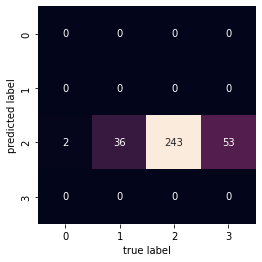

In [326]:
mat = confusion_matrix(val_y, pred_val)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Perhaps this bias issue can be solved with some hyperparameter tweaking.

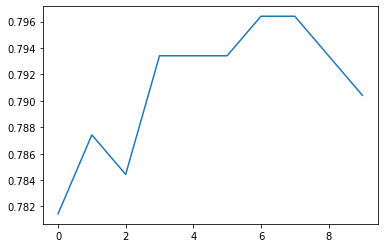

In [327]:
# plot f1_score as n_estimators is steadily increased from 10 to 1000 with intervals of 100
plt.plot([get_f1_accuracy(rf(tr_x_imp, tr_y, n_estimators=i), val_x_imp, val_y) for i in range(10,1000,100)])

It seems from here that accuracy is higher the more trees we have but with diminishing returns. So the optimal value seems to be about 600.

In [332]:
get_f1_accuracy(rf(tr_x_imp, tr_y, n_estimators=600), val_x_imp, val_y)

0.7874251497005988

Let's redefine our random forest with the new n_estimator.

In [329]:
def rf(xs, y, n_estimators=600, max_samples=425,
       max_features=0.5, min_samples_leaf=5, max_leaf_nodes=400, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, max_leaf_nodes=max_leaf_nodes, oob_score=True).fit(xs, y)



## Trial 9

Let's continue this sequence by playing with more hyperparameters. The next important hyperparams are `max_features` and `min_samples_leaf`.

Let's compare max_features first.

In [330]:
[get_f1_accuracy(rf(tr_x_imp, tr_y, max_features=i), val_x_imp, val_y) for i in ['sqrt', 'log2', 0.5]]

[0.7874251497005988, 0.7844311377245508, 0.7844311377245508]

It appears `sqrt` offers the highest accuracy. So let's switch `max_features` to that.

In [333]:
def rf(xs, y, n_estimators=600, max_samples=425,
       max_features='sqrt', min_samples_leaf=5, max_leaf_nodes=400, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, max_leaf_nodes=max_leaf_nodes, oob_score=True).fit(xs, y)

## Trial 10

For the final trial I will experiment with `min_samples_leaf`.

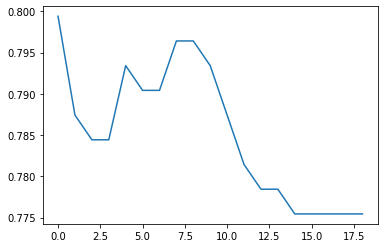

In [334]:
# plot f1_score as min_sample_leafs is steadily increased from 1 to 10
plt.plot([get_f1_accuracy(rf(tr_x_imp, tr_y, min_samples_leaf=i), val_x_imp, val_y) for i in range(1,20)])

Now it may seem that the graph is trending downwards and hence we should pick the highest value. However a `min_samples_leaf` of 1 will mean even one sample is enough for a leaf node. This may prevent some of the bias but it will also allow for more overfitting. I prefer to instead use the next peak of 6.

In [337]:
def rf(xs, y, n_estimators=600, max_samples=425,
       max_features='sqrt', min_samples_leaf=7, max_leaf_nodes=400, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, max_leaf_nodes=max_leaf_nodes, oob_score=True).fit(xs, y)

In [338]:
rfc = rf(tr_x_scaled, tr_y)
get_f1_accuracy(rfc, val_x_scaled, val_y)

0.7934131736526946

This is a pretty good score. I think its okay to stop here.

## Submission Preparation

Finally, I am done tweaking as much as I could. 😭😭😭

Let's generate an output so we can submit the results to the leaderboard.

In [344]:
# once you are happy with your local model, let's prepare a submission
# we need to apply the same preprocessing steps on the testing set as you did before you train the model

test_data = pd.read_csv('./drive/MyDrive/Colab Notebooks/test_new.csv').sample(frac=1) 
_id = test_data['id']
test_data = test_data.fillna(0)
test_data = test_data.drop(['merchant_id', 'merchant_profile_picture', 'id', 'tags'], axis=1)
test_data[cat_cols] = test_data[cat_cols].apply(lambda col: col.map(dict_cat[col.name]))

# again, not-seen string value filled with -1
test_data = test_data.fillna(-1)

test_data_imp = test_data[tr_x_imp.columns]

Remember that we need to acale the test features the same way we scaled our training and validation sets.

In [345]:
test_data_scaled = sc.transform(test_data_imp)
test_data_scaled[:3]

array([[-0.4170519 , -0.23809982,  0.40198556, -0.62364239, -1.80656359,
        -0.3034573 ,  1.28716723, -0.31667239,  0.81229756],
       [-0.43487119,  0.14233438,  0.34202046, -1.41871931,  0.59315337,
        -0.3034573 ,  0.30475651, -0.31667239, -1.46719829],
       [-0.40063939, -0.28529346, -1.73674964, -0.5788864 , -0.91625091,
        -0.3034573 , -0.42412887, -0.31667239, -1.37415764]])

In [341]:
test_data_scaled.shape, tr_x_scaled.shape

((479, 9), (759, 9))

In [342]:
pred_test = rfc.predict(test_data_scaled)
pred_df = pd.DataFrame(data={'id': np.asarray(_id), 'rating': pred_test})
pred_df.to_csv('preds_rohan.csv', index=False)